# Geographic analysis of patient flow - municipalities receiving more than 0.5% as poles

This notebook uses a geographic approach to **analyze the patient flow** through the municipalities in the Brazilian states. The first part of the analysis will be based on creating a **Voronoi diagram** from the centroids of municipalities defined as major healthcare poles. We will start with geographical distance but later refine it to road/highway-based distance. From this, we will obtain a Voronoi cell for each pole and observe whether patients are moving or not to the nearest pole to receive the health service. 

By analyzing the evolution of these data over the past 20 years for each Brazilian state, we can **evaluate the effectiveness of the regionalization process** in different regions of the country and in different moments of our recent history.

## Task Organization

1. Define the Voronoi seeds and plot the Voronoi diagram over the state map   

2. Create the origin-destination matrix and calculate the entropy   

---

### Part 1: Define the Voronoi seeds and plot the Voronoi diagram over the state map

- Found the centroid point for each municipality pole***** for the chosen Brazilian state (e.g. Bahia - BA)
- Plot the Voronoi diagram using these points as seeds
- Add the geographic map of the state as a layer 

  
#### * for now, we define a _Municipality Pole_ as a municipality receiving more than _0.5%_ of the total hospitalizations

#### Import and save the IBGE municipalities data

source (using 2019*): https://www.ibge.gov.br/geociencias/organizacao-do-territorio/malhas-territoriais

*buscar a malha territorial para os outros anos (2000, 2005, 2010, 2015-2019), quando necessario

*  using ["../prepare/prepare_data.ipynb"](../prepare/prepare_data.ipynb) notebook to generate both files below.

In [21]:

# choosing the Brazilian state (e.g. 'BA-29', 'SP-35', 'RJ-33')

UF = 'SP'
uf_code = 35


In [22]:
import pandas as pd
import geopandas as gpd

# import the municipalities shapes
mun_df = gpd.read_file("../data/%s/%s_mun.shp"%(UF, UF))

# import the patient flow data
df = pd.read_csv("../data/%s/%s_sih_flow.csv"%(UF, UF))

In [23]:
from shapely.geometry import Point

# create geometric point to centroid
mun_df['point'] = [Point(mun_df['centroid_x'][i], mun_df['centroid_y'][i]) for i in range(mun_df.shape[0])]

**Group and sum the last 5 years (2015-2019) flow data**

In [24]:
# The last 5 years entire flow data are used to run infomap (2020 data isn't entire)
flows = df[df['year']>=2015][df['year']<2020]

# Removing incoming/outcomming hospitalizations out from the choosen state
flows = flows[flows['mun_res']>uf_code*10000][flows['mun_res']<(uf_code+1)*10000]
flows = flows[flows['mun_cnes']>uf_code*10000][flows['mun_cnes']<(uf_code+1)*10000]

# Summing the hospitalizations for all years
flows = flows[['uf_code', 'mun_cnes', 'mun_res', 'nhospadm_total']].groupby(
    by = ['uf_code', 'mun_cnes', 'mun_res'], as_index = False).sum()

flows

<ipython-input-24-a2bf65b8be90>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flows = df[df['year']>=2015][df['year']<2020]
<ipython-input-24-a2bf65b8be90>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  flows = flows[flows['mun_res']>uf_code*10000][flows['mun_res']<(uf_code+1)*10000]


uf_code  mun_cnes   mun_res  nhospadm_total
0           35    350010  350010.0         14298.0
1           35    350010  350055.0             1.0
2           35    350010  350140.0            11.0
3           35    350010  350150.0             9.0
4           35    350010  350335.0            28.0
...        ...       ...       ...             ...
21685       35    355720  355030.0             6.0
21686       35    355720  355060.0             1.0
21687       35    355720  355220.0             1.0
21688       35    355720  355710.0             1.0
21689       35    355720  355720.0          5643.0

[21690 rows x 4 columns]

#### Import the patient flow data and restrict the Voronoi seeds to the municipalities pole

In [25]:
# get the number of hospitalizations each municipality had
hosp_per_mun = flows[['mun_cnes', 'nhospadm_total']].groupby(
    by = ['mun_cnes'], as_index = False).sum()

hosp_per_mun

mun_cnes  nhospadm_total
0      350010         26036.0
1      350050          7272.0
2      350070          8656.0
3      350100          5693.0
4      350110           463.0
..        ...             ...
337    355670         15274.0
338    355680          3242.0
339    355700         17199.0
340    355710         45067.0
341    355720          5755.0

[342 rows x 2 columns]

In [26]:
# get all municipalities recieving more than 0.5% of the total flows (the poles)

percent = 0.5

total_num_flows = flows['nhospadm_total'].sum()
min_num_flows = total_num_flows*percent*0.01

poles = hosp_per_mun[hosp_per_mun['nhospadm_total']>min_num_flows]

print("Total hospitalizations sum:", total_num_flows)
print("%.1f%% of total hospitalizations: %.2f"%(percent, min_num_flows))
print("%d/%d municipalities is a pole" %(poles.shape[0], mun_df.shape[0]))

Total hospitalizations sum: 13011040.0
0.5% of total hospitalizations: 65055.20
39/645 municipalities is a pole


In [27]:
poles_df = mun_df[mun_df['code'].isin(poles['mun_cnes'])]

poles_df.head()

name    code  centroid_x  centroid_y  \
31   Araçatuba  350280  -50.574498  -21.113858   
36  Araraquara  350320  -48.181322  -21.791650   
62    Barretos  350550  -48.651949  -20.514165   
64     Barueri  350570  -46.877250  -23.505279   
67       Bauru  350600  -49.126135  -22.253992   

                                             geometry  \
31  POLYGON ((-50.55536 -21.24069, -50.59958 -21.1...   
36  POLYGON ((-48.34075 -21.72993, -48.33082 -21.6...   
62  POLYGON ((-48.85260 -20.54301, -48.89433 -20.4...   
64  POLYGON ((-46.83848 -23.51062, -46.86286 -23.5...   
67  POLYGON ((-49.26211 -22.26748, -49.25665 -22.2...   

                                            point  
31  POINT (-50.57449808848379 -21.11385785585144)  
36  POINT (-48.18132248851061 -21.79164969751064)  
62  POINT (-48.65194948339299 -20.51416496343161)  
64  POINT (-46.87724966272073 -23.50527915954245)  
67  POINT (-49.12613467591029 -22.25399189168632)

In [28]:
import matplotlib.pyplot as plt

# plot map and centroids
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(poles_df['geometry']).plot(ax=ax, color="sandybrown")
gpd.GeoSeries(poles_df['point']).plot(ax=ax, markersize=2, color="red")
ax.axis("off")
plt.title("Pole municipalities in the State of %s"%UF)
plt.show()

In [29]:
from shapely.ops import cascaded_union
from shapely.geometry import Polygon
from geovoronoi import points_to_coords, voronoi_regions_from_coords
from geovoronoi.plotting import plot_voronoi_polys_with_points_in_area


state_boundary = Polygon(max(cascaded_union(mun_df['geometry']), key=lambda a: a.area).exterior)
poles_coords = points_to_coords(poles_df['point'])

# calculate Voronoi cells
voronoi_cells, seeds, cell_to_seed_assignments = voronoi_regions_from_coords(poles_coords, state_boundary.buffer(0.05))

# plot Voronoi cells 
fig, ax = plt.subplots(figsize=(10, 8))
plot_voronoi_polys_with_points_in_area(ax, state_boundary, voronoi_cells, seeds, 
                                       cell_to_seed_assignments, area_edgecolor='white')

ax.set_title("Voronoi Diagram for Municipalities pole* in %s"%UF)
ax.axis("off")
plt.show()

---
### Part 2: Create the origin-destination matrix and calculate the entropy 

- Create the OD matrix, where each line _i_ contains the number of patients residing in a Voronoi cell _i_ going to each Voronoi cell _j_
- Calculate the entropy of each line 

In [30]:
from geovoronoi import assign_points_to_voronoi_polygons

# create relation between the Voronoi cell and the municipalities inside it
#  where the array ith position contains the municipalities indexes to the ith cell
assignments = assign_points_to_voronoi_polygons(mun_df['point'], voronoi_cells)

# create a new column 'pole'
mun_df['pole'] = ""
poles_df = poles_df.reset_index(drop=True)
poles_df['cell'] = ""

# assign a pole to each municipality through the voronoi cells
for cell_i in range(len(assignments)):
    for mun_idx in assignments[cell_i]:
        mun_df.loc[mun_idx, 'pole'] = poles_df['code'].values[cell_to_seed_assignments[cell_i][0]]
    poles_df['cell'][cell_to_seed_assignments[cell_i][0]] = voronoi_cells[cell_i]

<ipython-input-30-b5b970d36e7f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  poles_df['cell'][cell_to_seed_assignments[cell_i][0]] = voronoi_cells[cell_i]


In [31]:
from shapely.geometry import MultiPoint
from shapely.ops import nearest_points

# assign a pole to the remaining municipalities through distance calc
#  (there are remaining municipalities when its centroid isn't inside any voronoi cell - like islands)

pts =  MultiPoint(poles_df['point'].values)
codes_empty_poles = mun_df[mun_df['pole'].isin([""])]['code']

for code in codes_empty_poles:
    pt = mun_df[mun_df['code']==code]['point'].values[0]
    nearest = nearest_points(pt, pts)[1]
    pole_code = poles_df[poles_df['point']==nearest]['code'].values[0]
    mun_df['pole'][mun_df[mun_df['code']==code].index[0]] = pole_code

<ipython-input-31-e50c9847b689>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mun_df['pole'][mun_df[mun_df['code']==code].index[0]] = pole_code


In [32]:
# create a origin-destination table
OD_table = pd.DataFrame(0, columns=poles_df['code'].values, index=poles_df['code'].values)

def pole(code):
    return mun_df[mun_df['code'] == code]['pole']

for flow in flows.values:
    a = pole(flow[2])
    b = pole(flow[1])
    if a.size > 0 and b.size > 0:
        OD_table.loc[int(a), int(b)] += flow[3]

OD_table.head()

350280    350320    350550    350570    350600   350750  350760  \
350280  317683.0      88.0   10342.0       5.0     805.0    515.0     3.0   
350320      26.0  150274.0    1370.0       2.0    1139.0     74.0     3.0   
350550      55.0     480.0  129284.0       0.0     220.0     26.0     1.0   
350570       9.0      26.0      54.0  123207.0     108.0     47.0     8.0   
350600      38.0    4965.0     173.0       5.0  211337.0  13247.0     3.0   

        350950  351060  351110  ...  354850  354870  354890   354980  354990  \
350280   161.0     2.0  1952.0  ...     9.0     6.0   208.0  44488.0    26.0   
350320   232.0     0.0   296.0  ...    10.0    17.0  1930.0    398.0    13.0   
350550    64.0     1.0   416.0  ...     3.0     1.0    18.0   3290.0    14.0   
350570   243.0  8562.0     7.0  ...    27.0    61.0     7.0      3.0    32.0   
350600   118.0     1.0    92.0  ...     6.0    20.0   138.0    267.0    21.0   

         355030  355220  355240  355280  355410  
350280   3164.0    71.0    20.0     8.0   107.0  
350320    949.0    21.0    10.0     2.0    28.0  
350550    655.0    52.0     8.0     3.0    10.0  
350570  28108.0   192.0    15.0   759.0   113.0  
350600   1503.0   118.0    10.0     3.0    68.0  

[5 rows x 39 columns]

In [33]:
f = plt.figure(figsize=(19, 15))
plt.matshow(OD_table, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-Destination Table', fontsize=16)
plt.show()

In [34]:
# each row is divided by its largest value
OD_table_row_normalized = OD_table.div(OD_table.sum(axis=1), axis=0)

# each column is divided by its largest value
OD_table_col_normalized = OD_table.div(OD_table.sum(axis=0), axis=1)

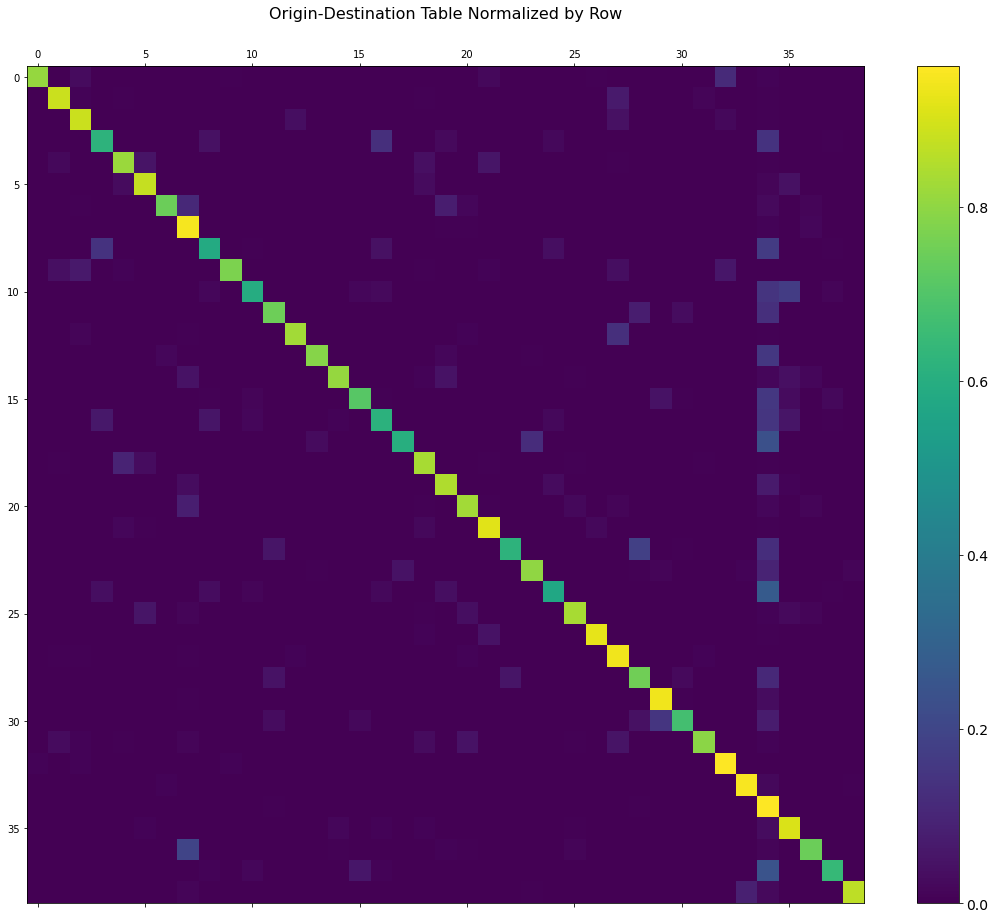

In [35]:
f = plt.figure(figsize=(19, 15))
plt.matshow(OD_table_row_normalized, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-Destination Table Normalized by Row', fontsize=16)
plt.show()

In [36]:
f = plt.figure(figsize=(19, 15))
plt.matshow(OD_table_col_normalized, fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Origin-Destination Table Normalized by Column', fontsize=16)
plt.show()

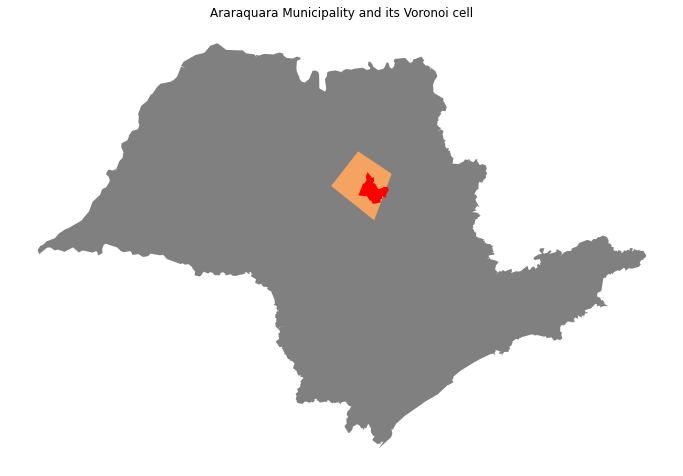

In [37]:
# plot a pole municipality and its Voronoi cell
x = 1
code = poles_df['code'].values[x]
fig, ax = plt.subplots(figsize=(12, 10))
gpd.GeoSeries(state_boundary).plot(ax=ax, color="gray")
gpd.GeoSeries(poles_df[poles_df['code'] == code]['cell']).plot(ax=ax, color="sandybrown")
gpd.GeoSeries(poles_df[poles_df['code'] == code]['geometry']).plot(ax=ax, color="red")
ax.axis("off")
plt.title("%s Municipality and its Voronoi cell"%poles_df[poles_df['code'] == code]['name'].values[0])
plt.show()

#### Calculate the entropy of each line

In [38]:
import geoplot
import mapclassify as mc

def plot_entropy_voronoi(geo_voronoi, flow_dir):
    scheme = mc.FisherJenks(geo_voronoi['entropy'].astype('float64'), k=10)

    if flow_dir == 'OUT':
        cmap = 'Reds'
        str1 = 'dispersion'
        str2 = 'going to'
    else:
        cmap = 'Blues'
        str1 = 'concentration'
        str2 = 'comming from'
        
    geoplot.choropleth(
        geo_voronoi, hue='entropy',
        edgecolor='gray', linewidth=1,
        cmap=cmap, figsize=(12, 10),
        legend=True, scheme=scheme
    )
    plt.title('''
                ENTROPY VALUE FOR EACH POLE %sFLOW
                Higher values means higher %s of patients %s other poles
                A good situation would be to have the patients flow inside its pole region (zero %s)
                (%d poles)
              '''%(flow_dir, str1, str2, str1, geo_voronoi.shape[0]))
    plt.show()

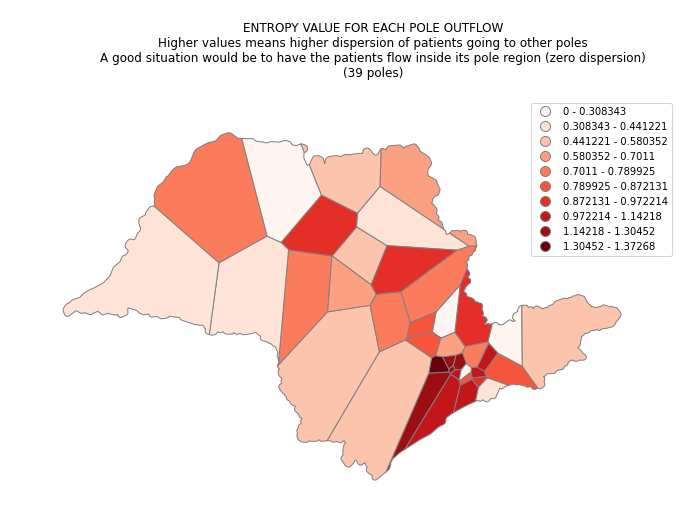

In [39]:
from scipy.stats import entropy

poles_df['out_entropy'] = entropy(OD_table_row_normalized, axis=1)
geo_voronoi = gpd.GeoDataFrame({'geometry': poles_df['cell'], 'entropy': poles_df['out_entropy']})

plot_entropy_voronoi(geo_voronoi, 'OUT')

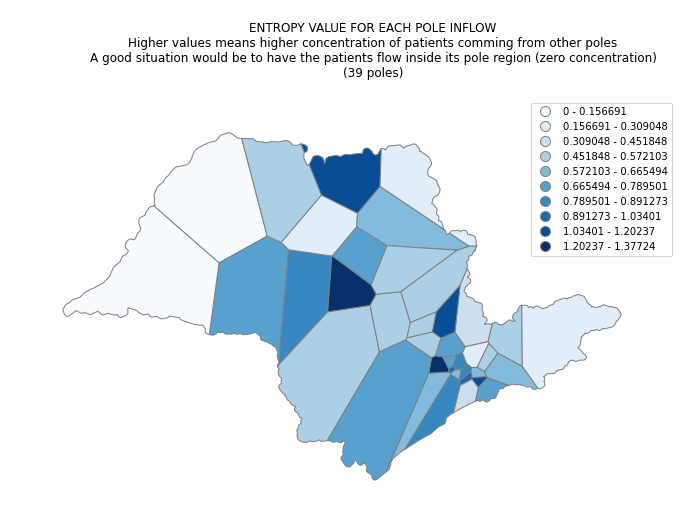

In [40]:
# REVER CODIGO PARA O 'INFLOW'

from scipy.stats import entropy

poles_df['in_entropy'] = entropy(OD_table_col_normalized, axis=0)
geo_voronoi = gpd.GeoDataFrame({'geometry': poles_df['cell'], 'entropy': poles_df['in_entropy']})

plot_entropy_voronoi(geo_voronoi, 'IN')